In [10]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from dateutil.relativedelta import relativedelta
import datetime
import statsmodels.api as sm
from scipy.optimize import brute
from itertools import product



# format notebook output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.core.display import display, HTML, Javascript
display(HTML("<style>.container { width:90% !important; }</style>"))

# style pandas display
pd.set_option('display.max_columns', None)

# matplotlib magic
%matplotlib inline

In [11]:
air_reserve = pd.read_csv('../../data_files/air_reserve.csv')
air_store_info = pd.read_csv('../../data_files/air_store_info.csv', encoding='utf-8')
air_visit_data = pd.read_csv('../../data_files/air_visit_data.csv')
date_info = pd.read_csv('../../data_files/date_info.csv')
hpg_reserve = pd.read_csv('../../data_files/hpg_reserve.csv')
hpg_store_info = pd.read_csv('../../data_files/hpg_store_info.csv')
sample_submission = pd.read_csv('../../data_files/sample_submission.csv')
store_id_relation = pd.read_csv('../../data_files/store_id_relation.csv')

In [32]:
air_stores = list(air_store_info['air_store_id'])
test = air_visit_data[air_visit_data['air_store_id']==air_stores[0]]
test.index = pd.DatetimeIndex(test['visit_date'])
display(test.head())

,air_store_id,visit_date,visitors
visit_date,,,
2016-07-01,air_0f0cdeee6c9bf3d7,2016-07-01,18
2016-07-02,air_0f0cdeee6c9bf3d7,2016-07-02,37
2016-07-03,air_0f0cdeee6c9bf3d7,2016-07-03,20
2016-07-04,air_0f0cdeee6c9bf3d7,2016-07-04,16
2016-07-05,air_0f0cdeee6c9bf3d7,2016-07-05,15


In [13]:
data_col = 'visitors'

def build_model(iter_param, series, params_list, static_param=None):
  if static_param==None:
    ords = iter_param
    sords = (1,0,0,0)
  else:
    ords = static_param
    sords = iter_param
  try:
    mod = sm.tsa.statespace.SARIMAX(
        series, trend='n', order=ords, seasonal_order=sords
      )
    res = mod.fit(disp=0)
    params_list.append(tuple((ords, sords, res.aic)))
  except:
    pass

'''m = []
res = build_model((1,0,0), test[data_col], m)
print('AIC: %s' % res.aic)
begin = len(test)-1
end = (datetime.datetime(2017,5,30).date()-test.index[-1].date()).days+len(test)
#res.predict(start=begin, end=end, dynamic=True)'''

"m = []\nres = build_model((1,0,0), test[data_col], m)\nprint('AIC: %s' % res.aic)\nbegin = len(test)-1\nend = (datetime.datetime(2017,5,30).date()-test.index[-1].date()).days+len(test)\n#res.predict(start=begin, end=end, dynamic=True)"

In [14]:
def parameter_search2(series, num_models, grid_diameter=3):
  models = []
  param_vals = range(grid_diameter)
  grid = list(product(param_vals,param_vals,param_vals))
  for ord_param in grid:
    for sord_param in [(p[0],p[1],p[2],7) for p in grid]:
      build_model(sord_param, series, models, ord_param)
  return sorted(models, key=lambda x: x[2])[:num_models]

In [9]:
def parameter_search(series, num_models, grid_diameter=3):
  ord_models = []
  sord_models = []
  grid = (slice(0, grid_diameter, 1), slice(0, grid_diameter, 1), slice(0, grid_diameter, 1))
  brute(build_model, grid, args=(series, ord_models), finish=None)
  for model in sorted(ord_models, key=lambda x: x[2])[:num_models]:
    grid = (slice(0, grid_diameter, 1), slice(0, grid_diameter, 1), slice(0, grid_diameter, 1), slice(7,8,1))
    brute(build_model, grid, args=(series, sord_models, model[0]), finish=None)
  return sord_models

In [15]:
mods = parameter_search2(test['visitors'], 5)

/Users/lee/kaggleVenv/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/lee/kaggleVenv/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/lee/kaggleVenv/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/lee/kaggleVenv/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/lee/kaggleVenv/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to c

/Users/lee/kaggleVenv/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/lee/kaggleVenv/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/lee/kaggleVenv/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/lee/kaggleVenv/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/lee/kaggleVenv/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to c

In [16]:
mods

[((0, 1, 2), (0, 1, 2, 7), 2084.1242605122929),
 ((0, 0, 1), (0, 1, 2, 7), 2084.369890003843),
 ((1, 1, 1), (0, 1, 2, 7), 2084.4700267206426),
 ((1, 0, 0), (0, 1, 2, 7), 2084.5706162980096),
 ((0, 1, 2), (2, 1, 1, 7), 2085.4832716194283)]

In [17]:
mod = sm.tsa.statespace.SARIMAX(test['visitors'], trend='n', order=(0, 1, 2), seasonal_order=(0,1,2,7))
best_model = mod.fit(disp=0)

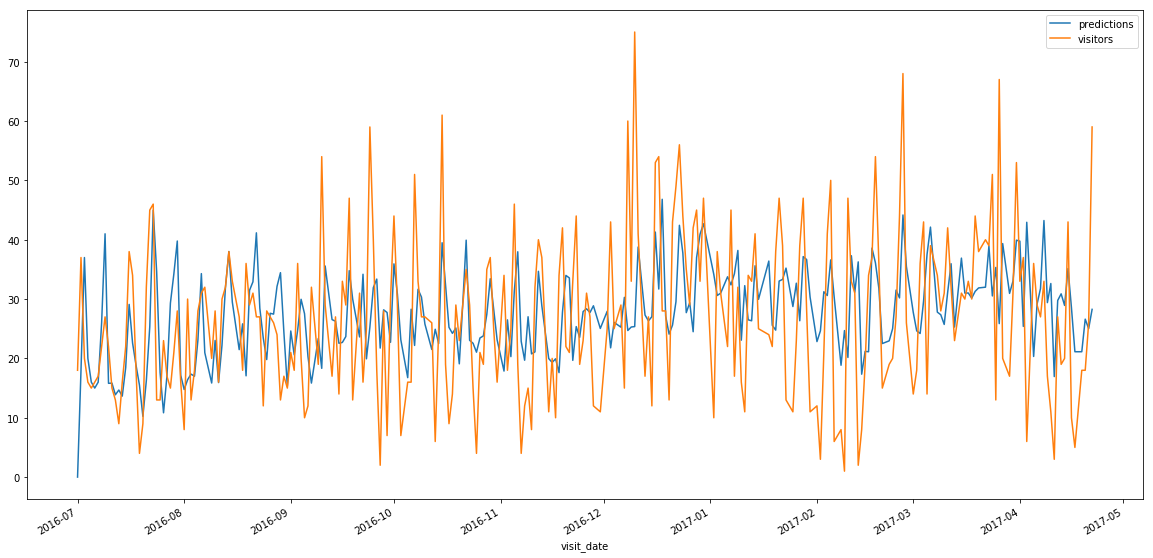

In [33]:
preds = best_model.predict()
test = test.assign(predictions=preds.values)
test[['predictions','visitors']].plot(figsize=(20,10))

In [26]:
display(test)

,air_store_id,visit_date,visitors,predictions
visit_date,,,,
2016-07-01,air_0f0cdeee6c9bf3d7,2016-07-01,18,0.000000
2016-07-02,air_0f0cdeee6c9bf3d7,2016-07-02,37,17.998379
2016-07-03,air_0f0cdeee6c9bf3d7,2016-07-03,20,36.996243
2016-07-04,air_0f0cdeee6c9bf3d7,2016-07-04,16,20.002354
2016-07-05,air_0f0cdeee6c9bf3d7,2016-07-05,15,16.001353
2016-07-06,air_0f0cdeee6c9bf3d7,2016-07-06,16,15.000440
2016-07-07,air_0f0cdeee6c9bf3d7,2016-07-07,17,16.000626
2016-07-08,air_0f0cdeee6c9bf3d7,2016-07-08,22,26.000009
2016-07-09,air_0f0cdeee6c9bf3d7,2016-07-09,27,40.997912
